In [221]:
import os
import sys
import imp
import pandas as pd
import matplotlib.pyplot as plt

from lib.consensus_utils import getConsensusDataFrame, getPresentValueList, rearrangeDataFrames
from lib.utils import fingerprint_default, name_default, bandwidth_default

In [201]:
file1 = os.listdir('csvs/')[1]
df = pd.read_csv('csvs/'+ file1, engine='python')

In [202]:
df

,fingerprint,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,0 21239CC313A28B3E6CEE48D949BF7787471B1519,5760,5760,5760,5760,5760,5760,5700,5600,5600,...,5600,5600,5600,5600,5600,5600,5600,5600,5600,5600
1,0000001dxx B9609624E26C705289E57F95E30FD88D159...,740,740,740,740,740,740,740,744,744,...,744,744,744,744,740,740,740,740,620,620
2,0001 2BD1936E0B4D5BB615CF99B0CFF74EAF19426888,6650,6650,6650,7190,7190,7190,7190,7190,7190,...,7500,7500,7500,7500,7500,7500,7500,7500,7190,7190
3,0ZQIX7g6 BB0C636DE89CAC6C995CB380AAC8C4AAAB731BA8,5600,5600,5290,5290,5290,5290,5600,5600,5600,...,5290,5290,5290,5290,5290,5290,4850,4850,4900,4850
4,0e4f10e596ff613288 7B258F55B16195A3DD864FC7D12...,378,378,433,433,433,433,480,480,480,...,480,480,480,480,480,480,480,480,480,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5747,zwiebelringXX DA4B488C2826DFBBD04D635DA1E71A2B...,74000,74000,74000,77000,76000,76000,76000,75600,76000,...,81000,81000,81000,81000,81000,82000,82000,82000,82000,76600
5748,zwiebeltoralf 63BF46A63F9C21FD315CD061B3EAA3EB...,76000,76000,76000,76000,76000,76000,76000,75000,75000,...,75000,74000,72000,72000,72000,72000,72000,72000,72000,72000
5749,zwiebeltoralf2 509EAB4C5D10C9A9A24B4EA0CE402C0...,85000,85000,85000,85000,85000,85000,85000,84000,84000,...,84000,82000,80100,80100,80100,80100,80100,80100,80100,80100
5750,zwiubel B0553175AADB0501E5A61FC61CEA3970BE130FF2,107000,84800,84800,115000,114000,114000,113000,112000,84800,...,84800,84800,84800,84800,84800,85000,85000,85000,85000,85000


In [220]:
i = 500
df.sort_values(by='0', ascending=False).reset_index().iloc[i:i+10]

,index,fingerprint,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
500,1287,MrDetonia 02928855BFAD787F8B363F21860D1E7D156E...,33000,33000,33000,33000,33000,33000,33000,33000,...,33000,33000,33000,33000,33000,33000,33000,33000,33000,33000
501,5256,texthtml 2D531C17827E0054DF612F26EEAAE51220CFE799,32900,32800,32800,32700,32600,32500,32400,32300,...,32000,32000,33000,33000,33000,33000,33000,33000,33000,33000
502,2016,TorOrDie4privacyNET 9423A72BBC8B5C6AC9DE9F5773...,32800,34000,34000,34000,34000,35000,34000,34000,...,34000,34000,34000,34000,34000,34000,34000,34000,34000,32800
503,2444,Unnamed 87C08DDFD32C62F3C56D371F9774D27BFDBB807B,32700,32700,32300,32200,32100,32000,31900,45000,...,45000,45000,45000,45000,45000,45000,45000,40000,34000,34000
504,2347,Unnamed 55A92BE2A76C64A5A0DB0D4F61D5DCA37B55EE52,32700,32600,32300,34500,31200,31100,31000,30900,...,31500,31500,31600,31700,32100,32400,32700,32800,33100,33300
505,1604,RESIST F31F27D3DAE86E9729FEE3A30354DE4704EE57FF,32600,32600,32600,32600,32600,32600,33000,33000,...,34400,34400,32600,32600,32600,32800,33100,33300,33600,33800
506,1536,PsychiCToRRelay 098907349C1190C4ADADB4482B51F5...,32600,32500,32000,31500,31200,31000,30900,30500,...,34600,34800,35100,35500,35600,33000,31000,31000,31000,31000
507,1396,OignonCA 54371D64F4AED8CD1EF8ED1B58C725C4063BDE42,32500,32400,36000,36000,36000,36000,36000,36000,...,36000,36000,31000,25500,25500,25700,25900,26100,26400,26500
508,1922,TheEpTicZeus 77A56CB237740E24AEA2D61C8C8936232...,32500,32500,32500,32500,32500,32500,32500,32500,...,34100,34100,29300,29300,29300,29300,29300,29300,30000,30000
509,691,FBIPartyTrain 94B7A0885AEFAF6CAD0D09930AA3026D...,32400,32500,32200,32000,31700,31500,31400,31100,...,39000,39000,39000,39000,39000,40000,48000,48000,48000,48000


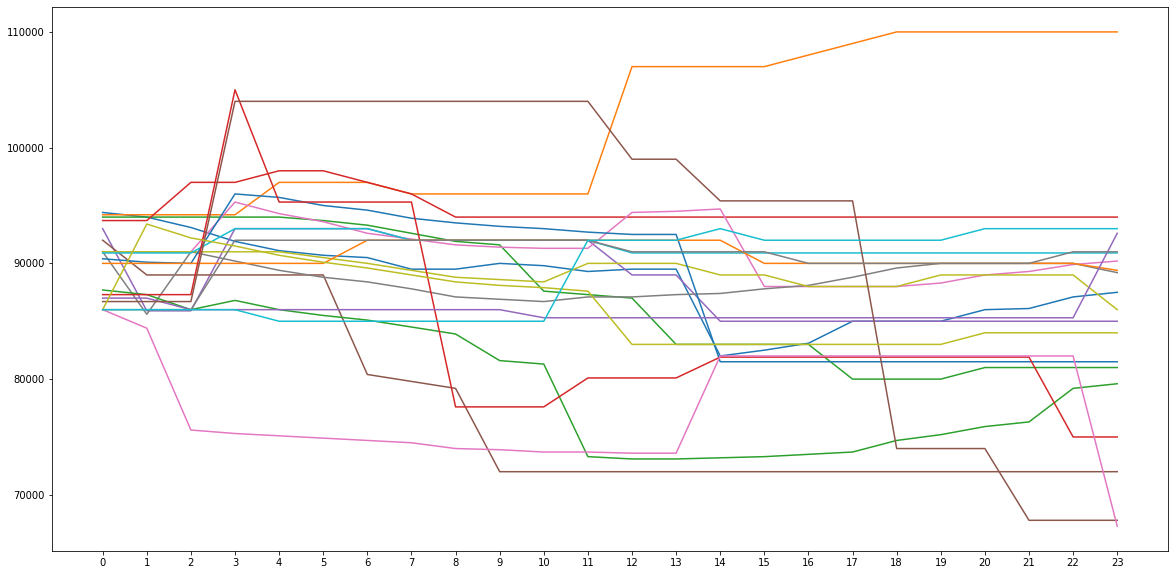

In [244]:
offset = 50
n = 20
plt.figure(figsize=(20,10))
for i in range(n):
    y = df.sort_values(by='0', ascending=False).reset_index().iloc[offset + i,2:]
    plt.plot(y)